In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset/dataset.zip -d /content/sample_data/

In [3]:
!cd /content/sample_data/archive/casting_data/casting_data/
!ls

drive  sample_data


### 모델 선언

### 학습량 설정

In [4]:
import torch

num_classes = 2
batch_size = 256
num_workers = 1
lr = 0.005

### 데이터 불러오기

In [5]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 경로 설정
data_dir = '/content/sample_data/archive/casting_data/casting_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [7]:
# transforms.Compose
#
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 이미지 사이즈 변경
        transforms.RandomHorizontalFlip(),  # 확률적으로 이미지를 수평으로 뒤집음
        # train 데이터를 랜덤으로 변형시켜서 학습 (overfitting 방지)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),             # 이미지 사이즈 변경 (전처리)
                                            # train으로 훈련시킨 모델의 정확도를 판별하기 위해 변형 X
        transforms.CenterCrop(224),         # 가운데를 224 사이즈로 자름
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
# 이미지 불러오기
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
                  for x in ['train', 'test']}

In [9]:
# DataLoader
dataloaders = {x: torch.utils.data.DataLoader(datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True,
                                              drop_last=False)
               for x in ['train', 'test']}

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 데이터 샘플 이미지

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

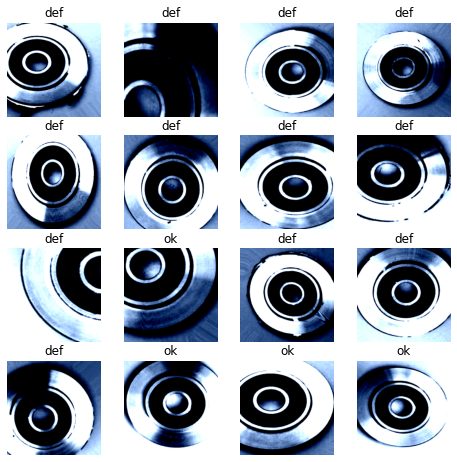

In [11]:
# sample에 이미지, label에 0(def), 1(ok) 저장
samples, labels = iter(dataloaders['train']).next()
classes = {0: 'def', 1: 'ok'}
fig = plt.figure(figsize=(8, 16))       # (8, 16) 사이즈의 영역
for i in range(16):
    a = fig.add_subplot(4, 4, i+1)      # fig 내부에 4행 4열을 만들고 하나씩 선택
    a.set_title(classes[labels[i].item()])  # 이미지에 classes로 제목
    a.axis('off')                   #    0        1      2
    # sample[i].numpy: (3, 224, 224): (channel, height, width) -> (height, width, channel)
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(top=0.5)

이미지 배열: height, width, channel

### 모델

In [12]:
from torch import nn

class SuperLightMobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(SuperLightMobileNet, self).__init__()
        
        # MobilNet v2
        #
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                # inp = input의 채널수 / 흑백 이미지: 채널수는 1개, RGB이미지: 채널수는 3개
                # oup = 출력되는 채널수
                nn.BatchNorm2d(oup),        # 각 batch 별로 평균, 분산을 이용해 정규화
                nn.ReLU(inplace=True)       # 미분값이 0보다 작아지면 0으로
                                            # -> 미분 값이 0으로 수렴하는 현상 방지
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.num_classes = num_classes

        self.model = nn.Sequential(
            conv_bn(  3,  16, 2),
            conv_dw( 16,  32, 1),
            conv_dw( 32, 64, 2),
            conv_dw(64, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
#           conv_dw(512, 512, 1),
#           conv_dw(512, 1024, 1)
        )
        # 2차원 배열을 1차원 배열로 
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # 1차원 
        self.fc = nn.Linear(512, self.num_classes)
        # x: 512개의 특성을 가진 데이터
        # y: 2개(ok, def)의 특성을 가진 데이터 배열

    def forward(self, x):
        x = self.model(x)       # 모델에 x 적용
        x = self.gap(x)         # x로 추출한 2차원 배열 값 -> 1차원 배열로 변경
        x = x.view(-1, 512)     # x tensor를 (?, 512)의 형태로 변환
                                # -> (1, 512)
        x = self.fc(x)          # 1차원 배열로 계산 -> Logit 혹은 score 출력
        return x

In [13]:
model = SuperLightMobileNet(num_classes).to(device)

In [14]:
# 예측값과 실제값의 오차
CEloss = nn.CrossEntropyLoss()
# loss의 최솟값을 찾는 알고리즘 (parameters 값을 조절)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 실행 코드

In [15]:
import numpy as np

epoch = 16
train_loss = [0]
test_loss = [0]
train_accu = [0]
test_accu = [0]

In [16]:
import time

for i in range(epoch):
    start_time = time.time()
    model.train()

    for input, target in dataloaders['train']:
        correct = 0
        total = 0

        images = input.to(device)
        labels = target.to(device)

        outputs = model(images)         # forward를 거쳐 나온 배열 (ok, def의 확률)
                                        # ex) {ok: 0.7, def: 0.3}
        loss = CEloss(outputs, labels)
        predicted = torch.max(outputs.data, 1)[1]       # forward에서 분류한 값 중 더 높은 확률로 분류한 값을 저장
                                                        # ex) predicted에 더 자주 분류된 ok 저장
        total += len(labels)
        correct += (predicted == labels).sum()

        loss.backward()         # 역전파, 파라미터들 에러의 변화도를 계산, 누적
        optimizer.step()        # loss를 효율적으로 최소화 할 수 있게 파라미터 수정 위탁
        optimizer.zero_grad()   # 이번 step에서 쌓은 파라미터들의 변화량을 0으로 초기화
                                # 다음 step에서는 다음 step에서의 변화량을 구하도록 함
    
    train_loss.append(loss)
    train_accu.append(100* correct/total)

    print('Epoch [{}/{}], Train Accuracy: {} %'.format(i+1, epoch, 100 * correct / total))

    model.eval()        # model.train(False)
    with torch.no_grad():
        for input, target in dataloaders['test']:
            correct = 0
            total = 0
            
            images = input.to(device)
            labels = target.to(device)

            # Forward pass
            outputs = model(images)
            loss = CEloss(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (predicted == labels).sum()

        test_loss.append(loss)
        test_accu.append(100* correct/total)

        print('Epoch [{}/{}], Test Accuracy: {} %'.format(i+1, epoch, 100 * correct / total))

        finish_time = time.time()
        Epoch_time = finish_time - start_time
        print(f"Epoch [{i+1}/{epoch}]: {int(Epoch_time)} seconds")

Epoch [1/16], Train Accuracy: 80.68669891357422 %
Epoch [1/16], Test Accuracy: 64.53202056884766 %
Epoch [1/16]: 29 seconds
Epoch [2/16], Train Accuracy: 87.12446594238281 %
Epoch [2/16], Test Accuracy: 74.38423156738281 %
Epoch [2/16]: 28 seconds
Epoch [3/16], Train Accuracy: 90.12875366210938 %
Epoch [3/16], Test Accuracy: 36.45320129394531 %
Epoch [3/16]: 28 seconds
Epoch [4/16], Train Accuracy: 95.27896881103516 %
Epoch [4/16], Test Accuracy: 90.64039611816406 %
Epoch [4/16]: 29 seconds
Epoch [5/16], Train Accuracy: 96.56652069091797 %
Epoch [5/16], Test Accuracy: 61.083744049072266 %
Epoch [5/16]: 28 seconds
Epoch [6/16], Train Accuracy: 96.56652069091797 %
Epoch [6/16], Test Accuracy: 68.47290802001953 %
Epoch [6/16]: 28 seconds
Epoch [7/16], Train Accuracy: 96.9957046508789 %
Epoch [7/16], Test Accuracy: 99.01477813720703 %
Epoch [7/16]: 28 seconds
Epoch [8/16], Train Accuracy: 93.99141693115234 %
Epoch [8/16], Test Accuracy: 58.12807846069336 %
Epoch [8/16]: 28 seconds
Epoch [9

model.train(), model.eval()  
: train과 evaluate 과정에 맞지 않는 layers를 무시 가능

# 시각화

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

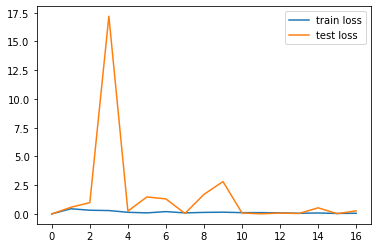

In [18]:
plt.plot(torch.Tensor(train_loss), label='train loss')
plt.plot(torch.Tensor(test_loss), label='test loss')
plt.legend()

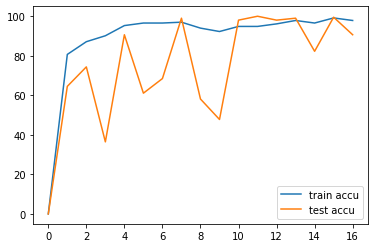

In [19]:
plt.plot([t for t in torch.Tensor(train_accu)], label='train accu')
plt.plot([t for t in torch.Tensor(test_accu)], label='test accu')
plt.legend()

10번째 이후로 train 데이터와 test 데이터의 정확도가 높고 비슷하게 나왔다.  
그 중에서도 둘의 차이가 크지 않으면서 정확도가 높은 15번째의 성능이 가장 좋다